# Global sistem çözümü

Bu derste ders 7 kapsamında daha önce gördüğümüz tüm bilgileri kullanarak global olarak sistemin tamamını çözümleyeceğiz. Çözeceğimiz problemi tekrar göz önüne getirelim:

<img src="Resimler/Ders7/2BoyutluProblem.png" align="center" width= "600"/>

İlk olarak problemin parametrelerini belirleyerek başlayalım:

In [227]:
L = 2    # m
H = 2    # m
D = 0.05 # m

q_1 = -500  # W/m2
q_2 = -1000 # W/m2
q_3 = -1500 # W/m2

T_sonsuz = 30 # C
T_sol = 80    # C
k = 5  # W/m2.K
h = 10 # W/m2K
h_z = 2*h/D

In [228]:
import sympy as sp
import numpy as np
from scipy import integrate
from sympy.utilities import lambdify

In [229]:
class Dikdörtgen():
    
    def __init__(self, L, H, nx, ny):
        
        x = np.linspace(0, L, nx+1)
        y = np.linspace(0, H, ny+1)
        ağ = np.meshgrid(x, y)

        noktalar = np.zeros(((nx+1)*(ny+1), 2), dtype=np.float32)
        elemanlar = np.zeros((nx*ny, 4), dtype=np.int32)

        nokta = 0
        for iy in range(ny + 1):
            for ix in range(nx + 1):
                noktalar[nokta, :] = x[ix], y[iy]
                nokta += 1

        eleman = 0
        for iy in range(ny):
            for ix in range(nx):
                v0 = iy*(nx + 1) + ix
                v1 = v0 + 1
                v2 = v0 + nx+1
                v3 = v1 + nx+1
                elemanlar[eleman, :] = v0, v1, v3, v2
                eleman += 1

        self.elemanlar = elemanlar
        self.noktalar = noktalar
        self.N = len(noktalar) # toplam nokta sayısı
        self.ağ = ağ

        self.sağ_kenar_noktalar = []
        self.üst_kenar_noktalar = []
        self.sol_kenar_noktalar = []
        self.alt_kenar_noktalar = []

        for indis, nokta in enumerate(self.noktalar):
            if np.isclose(nokta[0], L):
                self.sağ_kenar_noktalar.append(indis)
            if np.isclose(nokta[1], H):
                self.üst_kenar_noktalar.append(indis)
            if np.isclose(nokta[0], 0):
                self.sol_kenar_noktalar.append(indis)
            if np.isclose(nokta[1], 0):
                self.alt_kenar_noktalar.append(indis)
        
        eleman_id = np.arange(0,nx*ny)

        self.kenar_elemanlar = {'sağ':eleman_id[nx-1::nx],
                                'üst':eleman_id[-nx:],
                                'sol':eleman_id[0::nx],
                                'alt':eleman_id[:nx]
                                }

In [230]:
nx, ny = 2, 2
plaka = Dikdörtgen(L,H,nx,ny)

referans şekli ve global noktaları numaralarıyla göster

In [231]:
class FonksiyonUzayı():
    """
    Symbolic representation of the quadrilateral elements with four nodes
    """
    def __init__(self, mesh):
        self.mesh = mesh
        xi = sp.Symbol("xi")
        eta = sp.Symbol("eta")
        x_ = sp.symbols("x1,x2,x3,x4")
        y_ = sp.symbols("y1,y2,y3,y4")
        
        şekil = sp.Matrix([ (1-xi)*(1-eta)/4,
                            (1+xi)*(1-eta)/4,
                            (1+xi)*(1+eta)/4,
                            (1-xi)*(1+eta)/4])
        
        self.nokta_sayısı = 4

        gradyen_xi = sp.diff(şekil, xi)
        gradyen_eta = sp.diff(şekil, eta)

        gradyen = sp.Matrix([gradyen_eta, gradyen_xi])

        c_şekil = sp.Matrix([0, 0])
        for i in range(self.nokta_sayısı):
            c_şekil[0] += x_[i] * şekil[i]
            c_şekil[1] += y_[i] * şekil[i]

        self.gradyen = gradyen.reshape(2,4)
        self.şekil = şekil
        self.eta   = eta
        self.xi    = xi
        self.x_ = x_
        self.y_ = y_
        
        self.J = c_şekil.jacobian([xi, eta]).T
        self._dofmap = lambda e, r: self.mesh.elemanlar[e, r]
    
    def lokal_jakobyen(self, eleman_no):
        # Elemana ait noktaların global indislerini içeren dizi
        eleman_nokta_indisler = self.mesh.elemanlar[eleman_no]
        # Elemana ait koordinatların x ve y noktalarını içeren dizi
        eleman_noktalar = np.take(self.mesh.noktalar, eleman_nokta_indisler, axis=0)
        
        J = self.J

        for indis, nokta in enumerate(eleman_noktalar):
            J = J.subs(self.x_[indis],nokta[0]) # x koordinatı 
            J = J.subs(self.y_[indis],nokta[1]) # y koordinatı
        
        return J
    
    def K_e_eleman(self, eleman_no, k):

        J = self.lokal_jakobyen(eleman_no)

        K_e_sym = self.gradyen.T*(J**(-1)).T*k*(J**(-1))*self.gradyen*J.det()

        K_e = np.zeros((self.nokta_sayısı,self.nokta_sayısı))

        for i in range(self.nokta_sayısı):
            for j in range(self.nokta_sayısı):
                geçici_fonksiyon = lambdify( (self.xi,self.eta), K_e_sym[i,j], 'math' )
                K_e[i,j] += integrate.nquad(geçici_fonksiyon, [[-1, 1],[-1, 1]])[0]
                
        return K_e
    
    def K_t_eleman(self, eleman_no, h_z):

        J = self.lokal_jakobyen(eleman_no)

        K_t_sym = h_z*self.şekil*self.şekil.T*J.det()
    
        K_t = np.zeros((self.nokta_sayısı,self.nokta_sayısı))
        
        for i in range(self.nokta_sayısı):
            for j in range(self.nokta_sayısı):
                geçici_fonksiyon = lambdify( (self.xi,self.eta), K_t_sym[i,j], 'math' )
                K_t[i,j] += integrate.nquad(geçici_fonksiyon, [[-1, 1],[-1, 1]])[0]
        return K_t
    
    def f_e_1_eleman_yatay(self, eleman_no, q_eta, kenar):

        J = self.lokal_jakobyen(eleman_no)
            
        q_eta = sp.Matrix(q_eta)

        f_e_1_sym_yatay = self.şekil.multiply_elementwise(q_eta)*sp.sqrt(J[1,0]**2+J[1,1]**2)

        if kenar == 'üst':
            kenar_değer = 1
        elif kenar == 'alt':
            kenar_değer = -1

        f_e_1_sym_yatay = f_e_1_sym_yatay.subs(self.eta, kenar_değer) 

        f_e_1_yatay = np.zeros(self.nokta_sayısı)

        for i in range(self.nokta_sayısı):
            yatay_fonksiyon = lambdify( self.xi, f_e_1_sym_yatay[i], 'math' )
            f_e_1_yatay[i] += integrate.quad(yatay_fonksiyon, -1, 1)[0]
            
        return f_e_1_yatay
    
    def f_e_1_eleman_dikey(self, eleman_no, q_xi, kenar):

        J = self.lokal_jakobyen(eleman_no)
            
        q_xi  = sp.Matrix(q_xi)

        f_e_1_sym_dikey = self.şekil.multiply_elementwise(q_xi)*sp.sqrt(J[0,0]**2+J[0,1]**2)

        if kenar == 'sağ':
            kenar_değer = 1
        elif kenar == 'sol':
            kenar_değer = -1

        f_e_1_sym_dikey = f_e_1_sym_dikey.subs(self.xi,kenar_değer) 

        f_e_1_dikey = np.zeros(self.nokta_sayısı)

        for i in range(self.nokta_sayısı):
            dikey_fonksiyon = lambdify(self.eta, f_e_1_sym_dikey[i], 'math' )
            f_e_1_dikey[i] += integrate.quad(dikey_fonksiyon, -1, 1)[0]
            
        return f_e_1_dikey
    
    def f_e_2_eleman(self, eleman_no, h, t_z, T_sonsuz):

        J = self.lokal_jakobyen(eleman_no)

        h_z = 2*h/t_z

        f_e_2_sym = h_z*T_sonsuz*self.şekil*J.det()
        
        f_e_2 = np.zeros((self.nokta_sayısı,1))

        for i in range(self.nokta_sayısı):
            taşınım_fonksiyon = lambdify( (self.xi, self.eta), f_e_2_sym[i], 'math' )
            f_e_2[i] += integrate.nquad(taşınım_fonksiyon, [[-1, 1],[-1, 1]])[0]

        return f_e_2

In [232]:
V = FonksiyonUzayı(plaka)

In [233]:
np.set_printoptions(linewidth=150)

K_global = np.zeros((plaka.N, plaka.N))

for eleman_no, eleman in enumerate(plaka.elemanlar):
    K_lokal = V.K_e_eleman(eleman_no, k) + V.K_t_eleman(eleman_no,h_z)
    for lokal_x, global_x in enumerate(eleman):
        for lokal_y, global_y in enumerate(eleman):
            K_global[global_x][global_y] += K_lokal[lokal_x][lokal_y]

K_global

array([[ 47.77777778,  21.38888889,   0.        ,  21.38888889,   9.44444444,   0.        ,   0.        ,   0.        ,   0.        ],
       [ 21.38888889,  95.55555556,  21.38888889,   9.44444444,  42.77777778,   9.44444444,   0.        ,   0.        ,   0.        ],
       [  0.        ,  21.38888889,  47.77777778,   0.        ,   9.44444444,  21.38888889,   0.        ,   0.        ,   0.        ],
       [ 21.38888889,   9.44444444,   0.        ,  95.55555556,  42.77777778,   0.        ,  21.38888889,   9.44444444,   0.        ],
       [  9.44444444,  42.77777778,   9.44444444,  42.77777778, 191.11111111,  42.77777778,   9.44444444,  42.77777778,   9.44444444],
       [  0.        ,   9.44444444,  21.38888889,   0.        ,  42.77777778,  95.55555556,   0.        ,   9.44444444,  21.38888889],
       [  0.        ,   0.        ,   0.        ,  21.38888889,   9.44444444,   0.        ,  47.77777778,  21.38888889,   0.        ],
       [  0.        ,   0.        ,   0.        ,   9.4

In [234]:
q_x = np.zeros((plaka.N))
q_y = np.zeros((plaka.N))

q_y[plaka.üst_kenar_noktalar] += q_1
q_x[plaka.sağ_kenar_noktalar] += q_2
q_y[plaka.alt_kenar_noktalar] += q_3

In [235]:
f_global = np.zeros((plaka.N, 1))

for eleman in plaka.kenar_elemanlar['sağ']:
    q_xi = q_x[plaka.elemanlar[eleman]] 
    f_lokal_1 = V.f_e_1_eleman_dikey(eleman, q_xi, 'sağ')
    for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
        f_global[global_x] += f_lokal_1[lokal_x]

for eleman in plaka.kenar_elemanlar['üst']:
    q_eta = q_y[plaka.elemanlar[eleman]] 
    f_lokal_1 = V.f_e_1_eleman_yatay(eleman, q_eta, 'üst')
    for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
        f_global[global_x] += f_lokal_1[lokal_x]

for eleman in plaka.kenar_elemanlar['sol']:
    q_xi = q_x[plaka.elemanlar[eleman]] 
    f_lokal_1 = V.f_e_1_eleman_dikey(eleman, q_xi, 'sol')
    for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
        f_global[global_x] += f_lokal_1[lokal_x]

for eleman in plaka.kenar_elemanlar['alt']:
    q_eta = q_y[plaka.elemanlar[eleman]] 
    f_lokal_1 = V.f_e_1_eleman_yatay(eleman, q_eta, 'alt')
    for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
        f_global[global_x] += f_lokal_1[lokal_x]

for eleman_no, eleman in enumerate(plaka.elemanlar):
    f_lokal_2 = V.f_e_2_eleman(eleman_no, h, D, T_sonsuz)
    for lokal_x, global_x in enumerate(eleman):
        f_global[global_x] += f_lokal_2[lokal_x]

f_global

array([[ 2250.],
       [ 4500.],
       [ 1750.],
       [ 6000.],
       [12000.],
       [ 5000.],
       [ 2750.],
       [ 5500.],
       [ 2250.]])

In [236]:
alpha = [10e-12] * (ny+1) 
beta  = [1] * (ny+1)
gamma = [T_sol] * (ny+1)

# x=0'daki sınır koşulları
A = H/(ny+1)*D
for kenar_noktası, kenar in enumerate(plaka.sol_kenar_noktalar):

    K_global[kenar,kenar]+= 1*beta[kenar_noktası]*k*A/alpha[kenar_noktası]  
    f_global[kenar] += 1*gamma[kenar_noktası]*k*A/alpha[kenar_noktası]
# K_global

print(f_global)

[[1.33333334e+12]
 [4.50000000e+03]
 [1.75000000e+03]
 [1.33333334e+12]
 [1.20000000e+04]
 [5.00000000e+03]
 [1.33333334e+12]
 [5.50000000e+03]
 [2.25000000e+03]]


In [237]:
from scipy.linalg import solve
u = solve(K_global,f_global)
print(u)
u_plot = u.reshape(nx+1,ny+1)

[[79.99999978]
 [ 3.61646563]
 [16.27618081]
 [79.99999962]
 [24.46239928]
 [31.04295419]
 [79.9999998 ]
 [12.64368251]
 [22.70004302]]


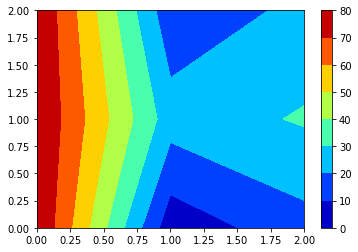

In [238]:
import matplotlib.pyplot as plt

X,Y = plaka.ağ

plt.contourf(X, Y, u_plot, cmap='jet')
plt.colorbar()